In [1]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime, timedelta
import timeit
from timeit import default_timer as timer
import glob
import os
from functools import reduce
#import matplotlib.pyplot as plt
import missingpy
from missingpy import KNNImputer
from fancyimpute import KNN
from fancyimpute import IterativeImputer
import scipy
from scipy.spatial.distance import pdist
from sklearn import preprocessing

Using TensorFlow backend.


In [3]:
### This Data set contains information about all the sensors which were reported as 'Good' on 25th Sept (Adopted from Caltrans website)
health_data = pd.read_csv('Good_Data_25thSept.csv',sep = ',')
#health_data.head()

In [4]:
## For initial analysis we will only select highway - US101S
health_data_US101S = health_data.loc[health_data['Fwy'] == 'US101-S']

### We do not need information about every lane of that sensor, just keeping the last observation to get the count of 
### number of lanes for that particular loop
health_data_US101S = health_data_US101S.drop_duplicates(subset=['VDS'],keep = 'last')
health_data_US101S = health_data_US101S.reset_index(drop = True)
#print(health_data_US101S.head())
#print(health_data_US101S.shape)

In [79]:
### Now as we know the list of sensors which reported good data on 25th Sept, we will try to get the data reported
### by them from the raw data we are collecting
li_processed_files = []
def pre_processing(day):
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    colnames = ["VDS_ID","Lane Count","Loop Count","Loop_1_FLOW","Loop_1_Occupancy","Loop_1_status","Loop_2_FLOW",
                "Loop_2_Occupancy", "Loop_2_status","Loop_3_FLOW","Loop_3_Occupancy","Loop_3_status","Loop_4_FLOW",
                "Loop_4_Occupancy","Loop_4_status","Loop_5_FLOW","Loop_5_Occupancy","Loop_5_status","Loop_6_FLOW",
                "Loop_6_Occupancy","Loop_6_status","Loop_7_FLOW","Loop_7_Occupancy","Loop_7_status","Loop_8_FLOW",
                "Loop_8_Occupancy","Loop_8_status","Loop_9_FLOW","Loop_9_Occuapncy","Loop_9_status","Loop_10_FLOW",
                "Loop_10_Occupancy","Loop_10_status"]
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            #df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            
            li_processed_files.append(df)
        else:
            continue 
    return li_processed_files

### This function is slow because of df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 

In [80]:
start = timer()
pre_processing('20190930')
end = timer()
print(f'Time required to process files : {end-start} seconds')

Time required to process files : 50.38128506601788 seconds


In [81]:
len(li_processed_files)

2040

In [82]:
## Saving the list of dataframes in another list as well just for safety
new_list = []
new_list = li_processed_files.copy()
print(len(new_list))

2040


In [83]:
li_processed_files = [dataframe.reset_index(drop = True) for dataframe in li_processed_files]

## Let us see how the first dataframe of the list look like
li_processed_files[0].head()
len(li_processed_files)
li_processed_files[0].shape

(2123, 22)

In [84]:
li_processed_files = [df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] for df in li_processed_files]
li_processed_files[0].shape

(81, 22)

In [85]:
start = timer()
## Now in order to find the euclidean distances between sensors, first we need to arrange their data in vector format.
temp_df = pd.concat(li_processed_files)


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    li_groups.append(group)
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

li_complete_groups = []
for dataframe in li_groups:
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe
data_KNN = pd.concat(li_complete_groups)
#print(data_KNN.shape)



## Let's see how the data looks like
data_KNN.head()

### need to impute the misssing values with zero to be able to calculate the distances 
### (otherwise getting null values in numpy array of distances) - There were not too many missing values since these sensors
### were in good health on 25th Sept. (less than 1% missing values)
data_KNN = data_KNN.fillna(0)

## check if there are still missing values
#len(data_KNN.index) - data_KNN.count()

## Change the data type to be able to calculate the distances
for col in data_KNN.columns:
    data_KNN[col] = data_KNN[col].astype(float)

## normalize the data before calculating the distances    
x = data_KNN.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_KNN_scaled = pd.DataFrame(x_scaled)

### Calculate the euclidean distances
mat = scipy.spatial.distance.cdist(data_KNN_scaled,data_KNN_scaled, metric='euclidean')
#print(f'distance_matrix_shape {mat.shape}')
#print(mat)

### Convert this array to a dataframe with index and column names

distances_df = pd.DataFrame(mat, index=data_KNN.index, columns=data_KNN.index)
#print(distances_df.head())



#############################################################################

################################# selecting neighbors and distances###########################

arr = np.argsort(-distances_df.values, axis=1)
df1 = pd.DataFrame(distances_df.columns[arr], index=distances_df.index)
### df1 dataframe contains names of the columns in every row sorted by values in each row (descending)
### therefore the last 6 columns are of neighbors

a = distances_df.values
a.sort(axis=1)
a = a[:,::-1]
sorted_distances_df = pd.DataFrame(a,distances_df.index,distances_df.columns)

### again the last 6 columns are of 6 least distances and can be treated as ED1, ED2, ED3, ED4, ED5 since K=5

    
for i,j in zip(range(1,6),range(2,7)):
    data_KNN["Neighbor{0}".format(i)] = df1.iloc[:,-j]
    data_KNN["distance{0}".format(i)] = sorted_distances_df.iloc[:,-j]



end = timer()

print(f'processing_time :{end-start} seconds')

data_KNN.head()

processing_time :34.54868732194882 seconds


time                2019-09-30 05:00:00  2019-09-30 05:00:30  \
Loop_1_FLOW_716328                  3.0                 16.0   
Loop_2_FLOW_716328                  9.0                 16.0   
Loop_3_FLOW_716328                  7.0                 11.0   
Loop_4_FLOW_716328                  7.0                  8.0   
Loop_1_FLOW_716331                  9.0                 15.0   

time                2019-09-30 05:01:00  2019-09-30 05:01:30  \
Loop_1_FLOW_716328                  2.0                  5.0   
Loop_2_FLOW_716328                  9.0                 10.0   
Loop_3_FLOW_716328                 15.0                  6.0   
Loop_4_FLOW_716328                 10.0                  8.0   
Loop_1_FLOW_716331                  4.0                  5.0   

time                2019-09-30 05:02:00  2019-09-30 05:02:30  \
Loop_1_FLOW_716328                  5.0                  7.0   
Loop_2_FLOW_716328                 10.0                  6.0   
Loop_3_FLOW_716328                  7.0                 10.0   
Loop_4_FLOW_716328                 10.0                 16.0   
Loop_1_FLOW_716331                  7.0                  8.0   

time                2019-09-30 05:03:00  2019-09-30 05:03:30  \
Loop_1_FLOW_716328                  8.0                  9.0   
Loop_2_FLOW_716328                 10.0                  8.0   
Loop_3_FLOW_716328                  7.0                  3.0   
Loop_4_FLOW_716328                 11.0                 10.0   
Loop_1_FLOW_716331                  7.0                  7.0   

time                2019-09-30 05:04:00  2019-09-30 05:04:30  ...  \
Loop_1_FLOW_716328                  6.0                  7.0  ...   
Loop_2_FLOW_716328                  8.0                  7.0  ...   
Loop_3_FLOW_716328                  9.0                 11.0  ...   
Loop_4_FLOW_716328                 15.0                  9.0  ...   
Loop_1_FLOW_716331                  8.0                 11.0  ...   

time                         Neighbor1  distance1           Neighbor2  \
Loop_1_FLOW_716328  Loop_2_FLOW_716328   5.348119  Loop_1_FLOW_764853   
Loop_2_FLOW_716328  Loop_1_FLOW_716328   5.348119  Loop_1_FLOW_716331   
Loop_3_FLOW_716328  Loop_1_FLOW_717446   5.582610  Loop_3_FLOW_716331   
Loop_4_FLOW_716328  Loop_2_FLOW_716328   6.251147  Loop_1_FLOW_716331   
Loop_1_FLOW_716331  Loop_2_FLOW_716331   4.589443  Loop_2_FLOW_717446   

time                distance2           Neighbor3  distance3  \
Loop_1_FLOW_716328   5.531788  Loop_2_FLOW_717446   5.704013   
Loop_2_FLOW_716328   6.021347  Loop_2_FLOW_716331   6.131411   
Loop_3_FLOW_716328   5.670257  Loop_1_FLOW_717450   5.807062   
Loop_4_FLOW_716328   6.375274  Loop_2_FLOW_716331   6.585738   
Loop_1_FLOW_716331   4.996474  Loop_3_FLOW_716331   5.421857   

time                         Neighbor4  distance4           Neighbor5  \
Loop_1_FLOW_716328  Loop_1_FLOW_716331   5.814760  Loop_3_FLOW_716328   
Loop_2_FLOW_716328  Loop_2_FLOW_717446   6.169249  Loop_2_FLOW_764853   
Loop_3_FLOW_716328  Loop_1_FLOW_716328   5.888838  Loop_2_FLOW_717446   
Loop_4_FLOW_716328  Loop_2_FLOW_717450   6.696043  Loop_2_FLOW_717446   
Loop_1_FLOW_716331  Loop_1_FLOW_717446   5.550147  Loop_1_FLOW_716328   

time                distance5  
Loop_1_FLOW_716328   5.888838  
Loop_2_FLOW_716328   6.192451  
Loop_3_FLOW_716328   5.954208  
Loop_4_FLOW_716328   6.754329  
Loop_1_FLOW_716331   5.814760  

[5 rows x 2050 columns]

In [103]:
data_KNN.head(20)

time                2019-09-30 05:00:00  2019-09-30 05:00:30  \
Loop_1_FLOW_716328                  3.0                 16.0   
Loop_2_FLOW_716328                  9.0                 16.0   
Loop_3_FLOW_716328                  7.0                 11.0   
Loop_4_FLOW_716328                  7.0                  8.0   
Loop_1_FLOW_716331                  9.0                 15.0   
Loop_2_FLOW_716331                 11.0                 15.0   
Loop_3_FLOW_716331                  8.0                 13.0   
Loop_4_FLOW_716331                  7.0                  7.0   
Loop_1_FLOW_716339                  6.0                  8.0   
Loop_2_FLOW_716339                 12.0                 13.0   
Loop_3_FLOW_716339                  4.0                  5.0   
Loop_4_FLOW_716339                  7.0                  9.0   
Loop_1_FLOW_716390                  3.0                 11.0   
Loop_2_FLOW_716390                  4.0                 11.0   
Loop_3_FLOW_716390                  2.0                  6.0   
Loop_4_FLOW_716390                  1.0                  1.0   
Loop_1_FLOW_716391                  4.0                  8.0   
Loop_2_FLOW_716391                  7.0                  7.0   
Loop_3_FLOW_716391                  4.0                  5.0   
Loop_4_FLOW_716391                  0.0                  2.0   

time                2019-09-30 05:01:00  2019-09-30 05:01:30  \
Loop_1_FLOW_716328                  2.0                  5.0   
Loop_2_FLOW_716328                  9.0                 10.0   
Loop_3_FLOW_716328                 15.0                  6.0   
Loop_4_FLOW_716328                 10.0                  8.0   
Loop_1_FLOW_716331                  4.0                  5.0   
Loop_2_FLOW_716331                  9.0                  8.0   
Loop_3_FLOW_716331                  7.0                  8.0   
Loop_4_FLOW_716331                  6.0                  6.0   
Loop_1_FLOW_716339                  8.0                  8.0   
Loop_2_FLOW_716339                  8.0                  7.0   
Loop_3_FLOW_716339                  2.0                  3.0   
Loop_4_FLOW_716339                  8.0                  8.0   
Loop_1_FLOW_716390                  7.0                  7.0   
Loop_2_FLOW_716390                  9.0                  7.0   
Loop_3_FLOW_716390                  5.0                  3.0   
Loop_4_FLOW_716390                  0.0                  1.0   
Loop_1_FLOW_716391                  4.0                  3.0   
Loop_2_FLOW_716391                  6.0                  6.0   
Loop_3_FLOW_716391                  7.0                  4.0   
Loop_4_FLOW_716391                  2.0                  2.0   

time                2019-09-30 05:02:00  2019-09-30 05:02:30  \
Loop_1_FLOW_716328                  5.0                  7.0   
Loop_2_FLOW_716328                 10.0                  6.0   
Loop_3_FLOW_716328                  7.0                 10.0   
Loop_4_FLOW_716328                 10.0                 16.0   
Loop_1_FLOW_716331                  7.0                  8.0   
Loop_2_FLOW_716331                 10.0                  8.0   
Loop_3_FLOW_716331                 12.0                  6.0   
Loop_4_FLOW_716331                  5.0                 11.0   
Loop_1_FLOW_716339                 10.0                  9.0   
Loop_2_FLOW_716339                  8.0                 10.0   
Loop_3_FLOW_716339                  3.0                  7.0   
Loop_4_FLOW_716339                  5.0                  8.0   
Loop_1_FLOW_716390                  4.0                  4.0   
Loop_2_FLOW_716390                  6.0                  4.0   
Loop_3_FLOW_716390                  4.0                  6.0   
Loop_4_FLOW_716390                  2.0                  2.0   
Loop_1_FLOW_716391                  4.0                  9.0   
Loop_2_FLOW_716391                  7.0                  8.0   
Loop_3_FLOW_716391                  4.0                  6.0   
Loop_4_FLOW_716391            

In [98]:
start = timer()
first_neighbor_vector = list(data_KNN.T.Loop_4_FLOW_764646[0:2040])
second_neighbor_vector = list(data_KNN.T.Loop_4_FLOW_772564[0:2040])
third_neighbor_vector = list(data_KNN.T.Loop_4_FLOW_772193[0:2040])
fourth_neighbor_vector = list(data_KNN.T.Loop_4_FLOW_716392[0:2040])
fifth_neighbor_vector = list(data_KNN.T.Loop_2_FLOW_770610[0:2040])
distance1 = 4.725522
distance2 = 4.768742
distance3 = 5.066604
distance4 = 5.130235
distance5 = 5.228068

imputed_vector = []
def KNN_Imputation(first_neighbor_vector,second_neighbor_vector,third_neighbor_vector,fourth_neighbor_vector,
                   fifth_neighbor_vector,distance1,distance2,distance3,distance4,distance5):
    #imputed_vector = []
    for n1, n2, n3, n4, n5 in zip(first_neighbor_vector,second_neighbor_vector,third_neighbor_vector,fourth_neighbor_vector,fifth_neighbor_vector):
        f = (n1*(1/distance1) + n2*(1/distance2) + n3*(1/distance3) + n4*(1/distance4) + n5*(1/distance5))/((1/distance1 + 1/distance2 + 1/distance3 + 1/distance4 + 1/distance5))
        imputed_vector.append(int(f))
        
KNN_Imputation(first_neighbor_vector,second_neighbor_vector,third_neighbor_vector,fourth_neighbor_vector,fifth_neighbor_vector,distance1,distance2,distance3,distance4,distance5)
#print(len(imputed_vector))

#imputed_vector = [int(f) for f in imputed_vector]




### Creating a dataframe of actual and imputed traffic flow

data  = pd.DataFrame(index = data_KNN.columns)
data = data.iloc[:-10]
#print(data.shape)
data['Actual'] = list(data_KNN.T.Loop_4_FLOW_776440[0:2040])
data['Using_KNN'] = imputed_vector
#data.head(10)

end = timer()

print(f'Imputation Time :{end-start} seconds')

Imputation Time :3.9077721580397338 seconds


In [99]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis

C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis


In [100]:
np.sqrt(np.mean((data.Using_KNN-data.Actual)**2))

2.6089965015495977

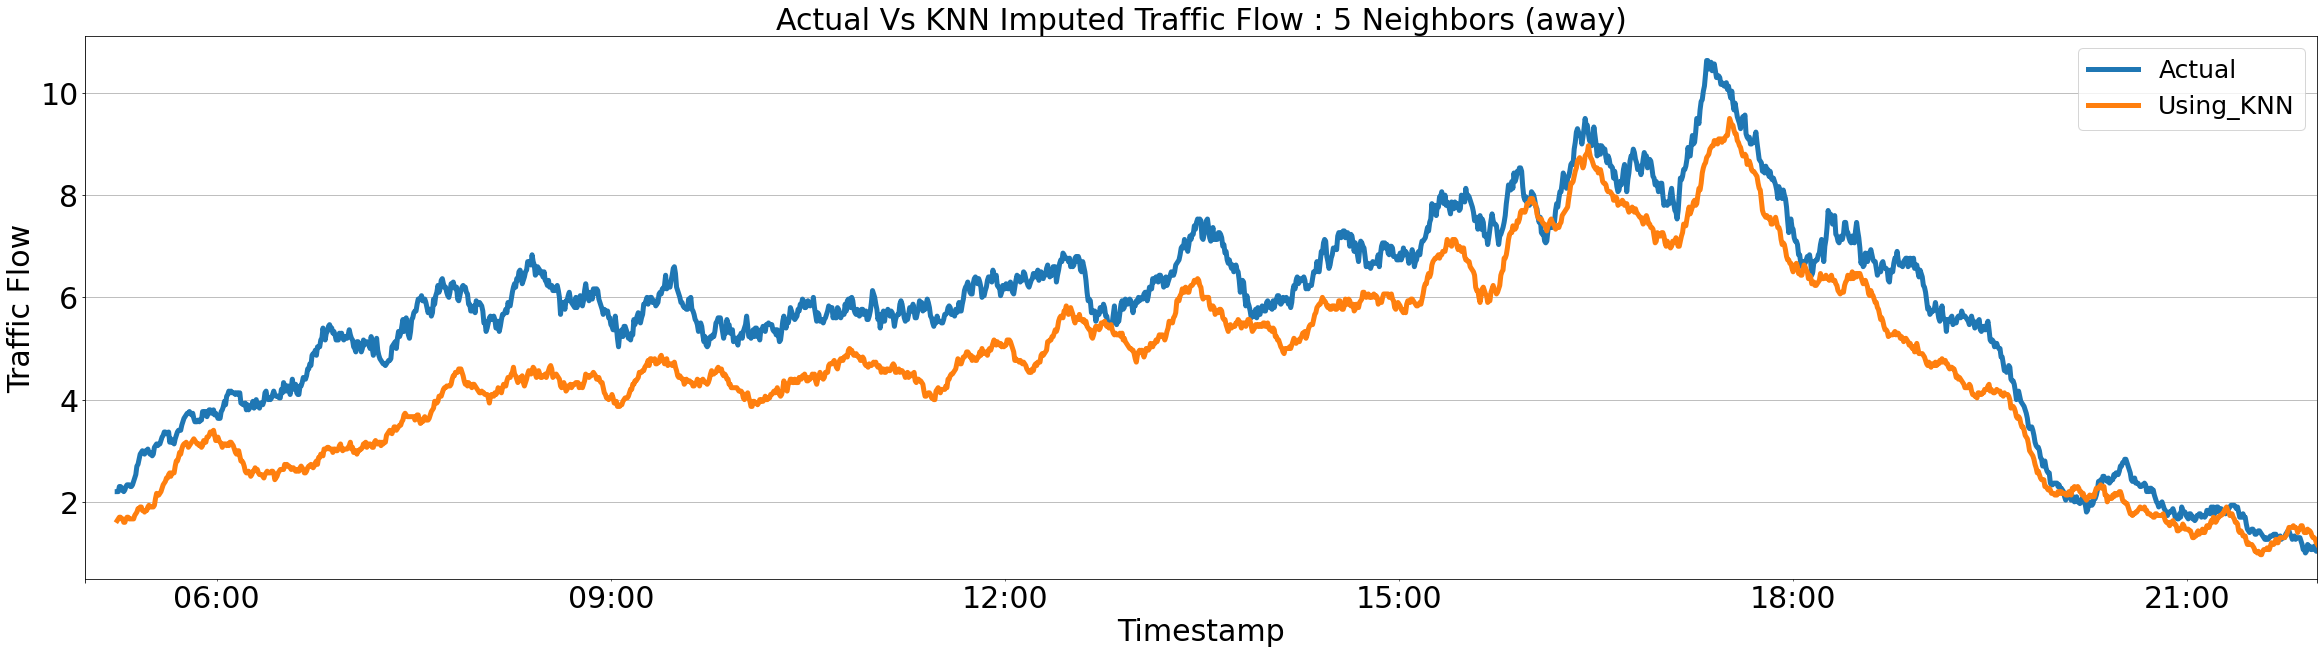

In [102]:
plt.close()
y = data.columns
for column in y:
    data[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Vs KNN Imputed Traffic Flow : 5 Neighbors (away)',fontsize = 30)
    #plt.savefig('KNN_5_neighbors_3.png')

In [ ]:
### Please ignore this cell


# for column in data_KNN.T.columns[[12,13,14,15]]:
#     data_KNN.T[column].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
#     plt.legend(y,fontsize = 25)
#     plt.xlabel('Timestamp',fontsize = 30)
#     plt.ylabel('Traffic Flow',fontsize = 30)
#     plt.xticks(rotation = 10)
#     plt.title('Before KNN Imputation',fontsize = 30)
#     #plt.savefig('Periodically_Missing_Flow_KNN_2.png')

# start = timer()
# imputer = KNNImputer(n_neighbors=3,weights="uniform")
# X_imputed = imputer.fit_transform(data_KNN)
# X_imputed = pd.DataFrame(X_imputed)
# end = timer()
# print(end - start) 

# X_imputed.columns = data_KNN.columns

# for column in X_imputed.T.columns[[12,13,14,15]]:
#     X_imputed.T[column].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
#     plt.legend(y,fontsize = 25)
#     plt.xlabel('Timestamp',fontsize = 30)
#     plt.ylabel('Traffic Flow',fontsize = 30)
#     plt.xticks(rotation = 10)
#     plt.title('Before KNN Imputation',fontsize = 30)
#     #plt.savefig('Periodically_Missing_Flow_KNN_2.png')

# start = timer()
# X_filled_knn = KNN(k=3).fit_transform(data_KNN)
# print(timer()-start)

# X_filled_knn = pd.DataFrame(X_filled_knn)
# for column in X_filled_knn.T.columns[[12,13,14,15]]:
#     X_filled_knn.T[column].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
#     plt.legend(y,fontsize = 25)
#     plt.xlabel('Timestamp',fontsize = 30)
#     plt.ylabel('Traffic Flow',fontsize = 30)
#     plt.xticks(rotation = 10)
#     plt.title('Before KNN Imputation',fontsize = 30)
#     #plt.savefig('Periodically_Missing_Flow_KNN_2.png')


### This is for I Step

# first_neighbor_vector = list(data_KNN.T.Loop_3_FLOW_776328[0:2036])
# second_neighbor_vector = list(data_KNN.T.Loop_1_FLOW_776328[0:2036])
# distance1 = 5.789405
# distance2 = 5.980127

# def KNN_Imputation(first_neighbor_vector,second_neighbor_vector,distance1,distance2):
#     imputed_vector = []
#     for n1, n2 in zip(first_neighbor_vector,second_neighbor_vector):
#         f = (n1*(1/distance1) + n2*(1/distance2))/((1/distance1 + 1/distance2))
#         imputed_vector.append(int(f))
        
# KNN_Imputation(first_neighbor_vector,second_neighbor_vector,distance1,distance2)
# print(len(imputed_vector))

# imputed_vector = [int(f) for f in imputed_vector]

In [ ]:
# Please ignore this cell
analysis = pd.DataFrame(index = data_KNN.index.str[12:18])
for i in range(1,6):
    analysis["N{0}".format(i)] = data_KNN["Neighbor{0}".format(i)].str.split('W').apply(lambda x: int(x[1][1:])).values

analysis
# analysis.dtypes

# both_neighbors_at_same_location = 0
# one_neighbor_at_same_location = 0
# both_neigbors_from_different_locations = 0
# for index,row in analysis.iterrows():
#     if int(index) == row[0] and int(index) == row[1]:
#         both_neighbors_at_same_location += 1
#     elif (int(index) == row[0] and int(index) != row[1]) or (int(index) != row[0] and int(index) == row[1]):
#         one_neighbor_at_same_location += 1
#     elif int(index) != row[0] and int(index) != row[1]:
#         both_neigbors_from_different_locations += 1
    
        
# print(f'both_neighbors_at_same_location: {both_neighbors_at_same_location}') 
# print(f'one_neighbor_at_same_location {one_neighbor_at_same_location}')
# print(f'both_neigbors_from_different_locations {both_neigbors_from_different_locations}')

# for index, row in analysis.iterrows():
#     if int(index) == row[0]:
#         ### 
#     else:
        
        
        
    
    



In [ ]:
prob_1st_neighbor_same_location = 0
for index,row in analysis.iterrows():
    if int(index) == row[0]:
        prob_1st_neighbor_same_location += 1
        
print((prob_1st_neighbor_same_location/analysis.shape[0])*100)

prob_1st_neighbor_same_location

In [ ]:
for index, row in analysis.iterrows():
    if index != row[0] and index != row[1] and index != row[2] and index != row[3]  and index != row[4]:
        print(index)

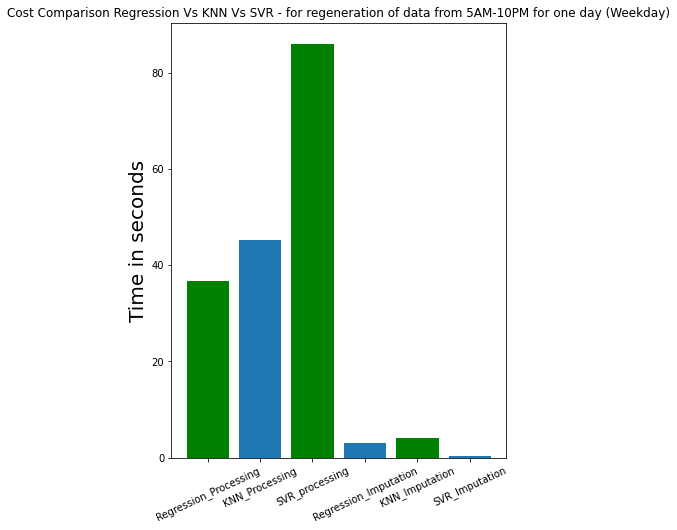

In [26]:
## This cell is for the purpose of creating graphs for timings

height = [36.7, 45.20, 86, 3, 4.06, 0.34]

bars = ('Regression_Processing', 'KNN_Processing','SVR_processing','Regression_Imputation','KNN_Imputation',
       'SVR_Imputation')

y_pos = np.arange(len(bars))

f, ax = plt.subplots(figsize=(6,8),linewidth=5)
barlist = plt.bar(y_pos, height)
barlist[0].set_color('g')
barlist[2].set_color('g')
barlist[4].set_color('g')

plt.xticks(y_pos, bars)
plt.xticks(rotation = 25)
plt.ylabel('Time in seconds',fontsize = 20)
plt.title('Cost Comparison Regression Vs KNN Vs SVR - for regeneration of data from 5AM-10PM for one day (Weekday)')

#plt.savefig('Time Comparison KNN Vs Regression.png')
#plt.grid()
plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label,fontsize = 15)

    plt.legend()

#     if grid:
#         plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

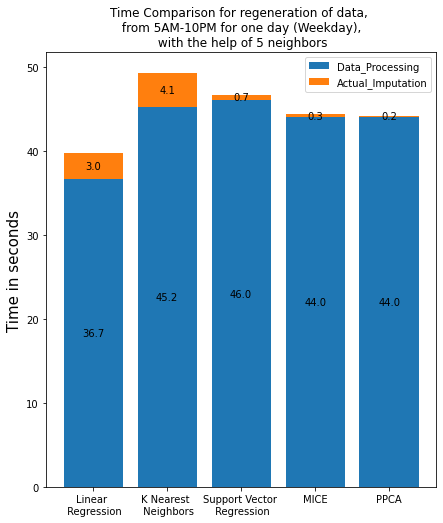

In [62]:

plt.figure(figsize = (7,8))

series_labels = ['Data_Processing','Actual_Imputation']

data = [
    [36.7, 45.20, 46, 44, 44],
    [3, 4.06, 0.69, 0.34, 0.17]    
]

category_labels = ['Linear \n Regression','K Nearest \n Neighbors','Support Vector \n Regression', 'MICE','PPCA']

stacked_bar(
data,
series_labels,
category_labels=category_labels,
show_values = True,
value_format="{:.1f}",
y_label="Time in seconds"  
)

plt.title('Time Comparison for regeneration of data, \n from 5AM-10PM for one day (Weekday), \n with the help of 5 neighbors')
plt.savefig('Time_Comparisons_stacked_barplot.png')
plt.show()

In [ ]:
data_KNN.head(10)

In [ ]:
start = timer()
## Now in order to find the euclidean distances between sensors, first we need to arrange their data in vector format.
temp_df = pd.concat(li_processed_files)


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    li_groups.append(group)
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

li_complete_groups = []
for dataframe in li_groups:
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe
data_MICE = pd.concat(li_complete_groups)
#print(data_KNN.shape)



## Let's see how the data looks like
data_MICE.head()

### need to impute the misssing values with zero to be able to calculate the distances 
### (otherwise getting null values in numpy array of distances) - There were not too many missing values since these sensors
### were in good health on 25th Sept. (less than 1% missing values)
data_MICE = data_MICE.fillna(0)

## check if there are still missing values
#len(data_KNN.index) - data_KNN.count()

## Change the data type to be able to calculate the distances
for col in data_MICE.columns:
    data_MICE[col] = data_MICE[col].astype(float)

end = timer()

print(end-start)

data_MICE.head()

In [ ]:
plt.close()
y = data_MICE.T.columns[0:2]
for column in y:
    data_MICE.T[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Check',fontsize = 30)
    #plt.savefig('KNN Data Re-generation_10.png')

In [ ]:
actual_data = pd.DataFrame(data_MICE[1:70].iloc[:,240:440])
actual_data.head()

actualflow1 = actual_data[0:1].iloc[:,30:140].T['Loop_2_FLOW_716328']
actualflow1

In [ ]:
trial_mice_imputed.head()
imputedflow1 = trial_mice_imputed[0:1].iloc[:,30:140].T['Loop_2_FLOW_716328']
imputedflow1

In [ ]:
actualflow1.rolling(6).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
imputedflow1.rolling(6).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
plt.legend(fontsize=25)

In [ ]:
import random
ix = [(row, col) for row in range(df.shape[0]) for col in range(df.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):
    df.iat[row, col] = np.nan

In [ ]:
### selecting few rows and few columns for performing MICE
trial = data_MICE[1:70].iloc[:,240:440]
plt.close()
y = trial.T.columns[0:3]
for column in y:
    trial.T[column].rolling(20).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Data',fontsize = 30)
    #plt.savefig('Mice_Original.png')
    
#print('done')  
trial.head()

In [ ]:
plot_actual = trial[0:2].iloc[:,30:100]
print(plot_actual.shape)

# plot_imputed = trial_mice_imputed[0:2].iloc[:,30:100]
# plot_imputed.head()

# print(plot_imputed.shape)

# plot_actual.head()

# plot_imputed.T['Loop_2_FLOW_716328'] = plot_imputed.T['Loop_2_FLOW_716328'].round(0).astype(int)
# plot_imputed.T['Loop_3_FLOW_716328'] = plot_imputed.T['Loop_3_FLOW_716328'].round(0).astype(int)
# plot_imputed.T.head()

pd.options.display.float_format = '{:,.0f}'.format
plot_imputed.head()
#plot_actual.head()

In [ ]:
# y = plot_actual.T.columns[0]
# plt.close()
# for column in y:
plt.close()
actual1 = plot_actual.T['Loop_2_FLOW_716328']
# imputed1 = plot_imputed.T['Loop_2_FLOW_716328']
# actual1.rolling(2).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
# imputed1.rolling(2).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
# plt.legend(y,fontsize = 25)
# #     plt.xlabel('Timestamp',fontsize = 30)
# #     plt.ylabel('Traffic Flow',fontsize = 30)
# #     plt.xticks(rotation = 10)
# #     plt.grid()
# #     plt.title('Missing Data',fontsize = 30)
# #     #plt.savefig('Mice_Missing.png')

In [ ]:
trial[0:2].iloc[:,30:140] = np.nan
y = trial.T.columns[0:1]
plt.close()
for column in y:
    trial.T[column].rolling(20).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Missing Data',fontsize = 30)
    #plt.savefig('Mice_Missing.png')

In [ ]:
start = timer()
# Copy dataset with missing valeus to trial_mice_imputed
trial_mice_imputed = trial.copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on dataset(trial)
trial_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(trial)

end = timer()

print(end-start)

In [ ]:
y = trial_mice_imputed.T.columns[0:1]
plt.close()
actual1.rolling(20).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
trial_mice_imputed.T[y].rolling(20).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
plt.legend(y,fontsize = 25)
#     plt.xlabel('Timestamp',fontsize = 30)
#     plt.ylabel('Traffic Flow',fontsize = 30)
#     plt.xticks(rotation = 10)
#     plt.grid()
#     plt.title('MICE Iteration1',fontsize = 30)
#     #plt.savefig('MICE Iteration1.png')


In [ ]:
#### 3rd October

### selecting few rows and few columns for performing MICE
mice_sample = data_MICE[0:70].iloc[:,0:1000]
plt.close()
y = mice_sample.T.columns[0:3]
for column in y:
    mice_sample.T[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Data',fontsize = 30)
    #plt.savefig('Mice_Original.png')
    
#print('done')  

In [ ]:
mice_sample[0:2]

In [ ]:
mice_sample[0:2].iloc[:,100:900] = np.nan
y = mice_sample.T.columns[0:3]
plt.close()
for column in y:
    mice_sample.T[column].rolling(20).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Missing Data',fontsize = 30)
    #plt.savefig('Mice_Missing.png')

In [ ]:
# Copy dataset with missing valeus to trial_mice_imputed
trial_mice_imputed = mice_sample.copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on dataset(trial)
trial_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(mice_sample)

In [ ]:
trial_mice_imputed.T[y].rolling(20).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)

In [ ]:
actual1 = data_MICE[0:2].iloc[:,240:440].T.Loop_2_FLOW_716328

actual1.rolling(20).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)